# Learning and defining a causal model

### First we need to import some modules

In [4]:
# helpper cell
#!pip install graphviz

In [2]:
import os 
from pprint import pprint

import matplotlib.pyplot as plt
import pandas as pd
import pgmpy.models

%matplotlib inline

/mnt/c/Users/maximilian.kurthen/OneDrive - b.telligent/Projects/2021_01_SpringerFachbuch/caus_inf/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [6]:
from graphviz import Digraph

dot = Digraph()
dot.node('A', 'A')
dot.node('B', 'B')
dot.node('C', 'C')
dot.edges(['AB', 'AB', 'AB', 'BC', 'BA', 'CB'])

print(dot.source)
dot.render("abc.test", view=True)

digraph {
	A [label=A]
	B [label=B]
	C [label=C]
	A -> B
	A -> B
	A -> B
	B -> C
	B -> A
	C -> B
}


ExecutableNotFound: failed to execute ['dot', '-Kdot', '-Tpdf', '-O', 'abc.test'], make sure the Graphviz executables are on your systems' PATH

### now we read the dataset, we use the IBM Employee Attition Dataset here

In [7]:
data = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
pprint(list(data.columns))
data.head()


['Age',
 'Attrition',
 'BusinessTravel',
 'DailyRate',
 'Department',
 'DistanceFromHome',
 'Education',
 'EducationField',
 'EmployeeCount',
 'EmployeeNumber',
 'EnvironmentSatisfaction',
 'Gender',
 'HourlyRate',
 'JobInvolvement',
 'JobLevel',
 'JobRole',
 'JobSatisfaction',
 'MaritalStatus',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'Over18',
 'OverTime',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StandardHours',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


### get rid of unneccessary columns:


In [8]:
# Employee Count and StandardHours contain 1 resp. 80 for every record, so we can drop them
unnecessary_columns = ["EmployeeCount", "StandardHours"] 
data = data.drop(columns=unnecessary_columns)

### we could try to learn the structure from the data, but we can also think about what we can influence.
In the end we care about attrition. We suppose, attrition is an effect of Job Satisfaction, but we cannot influence the job satisfaction itself. 
Instead we could influence
* increase daily rate
* decrease Business Travel
* reduce OverTime



In [9]:
import pgmpy.models
model = pgmpy.models.BayesianModel([("BusinessTravel", "JobSatisfaction", )])
model.fit(data)

### now we need to model the query. What can we do to influence Job Satisfaction?
Let's suppose we could 

Currently, Job Satisfaction is distrubuted as following

In [10]:
import networkx as nx
from sklearn.metrics import f1_score
import numpy as np

In [11]:
# Funtion to evaluate the learned model structures.
def get_f1_score(estimated_model, true_model):
    nodes = estimated_model.nodes()
    est_adj = nx.to_numpy_matrix(estimated_model.to_undirected(), nodelist=nodes, weight=None)
    true_adj = nx.to_numpy_matrix(true_model.to_undirected(), nodelist=nodes, weight=None)
    
    f1 = f1_score(np.ravel(true_adj), np.ravel(est_adj))
    print("F1-score for the model skeleton: ", f1)


In [12]:
from pgmpy.estimators import PC, HillClimbSearch, ExhaustiveSearch
est = PC(data=data)
#estimated_model = est.estimate(variant='stable', max_cond_vars=4)
#get_f1_score(estimated_model, model)
estimated_model = est.estimate(variant='orig', max_cond_vars=4)



Working for n conditional variables: 4: 100%|██████████| 4/4 [00:40<00:00, 11.49s/it]/mnt/c/Users/maximilian.kurthen/OneDrive - b.telligent/Projects/2021_01_SpringerFachbuch/caus_inf/lib/python3.9/site-packages/pgmpy/estimators/PC.py:366: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 4: 100%|██████████| 4/4 [00:40<00:00, 10.09s/it]


In [15]:
print(estimated_model.edges)


[('TotalWorkingYears', 'YearsWithCurrManager'), ('TotalWorkingYears', 'Age'), ('Age', 'YearsAtCompany'), ('Department', 'JobRole'), ('HourlyRate', 'MaritalStatus'), ('Education', 'NumCompaniesWorked'), ('NumCompaniesWorked', 'Age'), ('PerformanceRating', 'PercentSalaryHike'), ('JobLevel', 'TotalWorkingYears'), ('MonthlyIncome', 'YearsWithCurrManager'), ('StockOptionLevel', 'MaritalStatus'), ('BusinessTravel', 'PercentSalaryHike'), ('OverTime', 'Attrition'), ('EducationField', 'Department')]


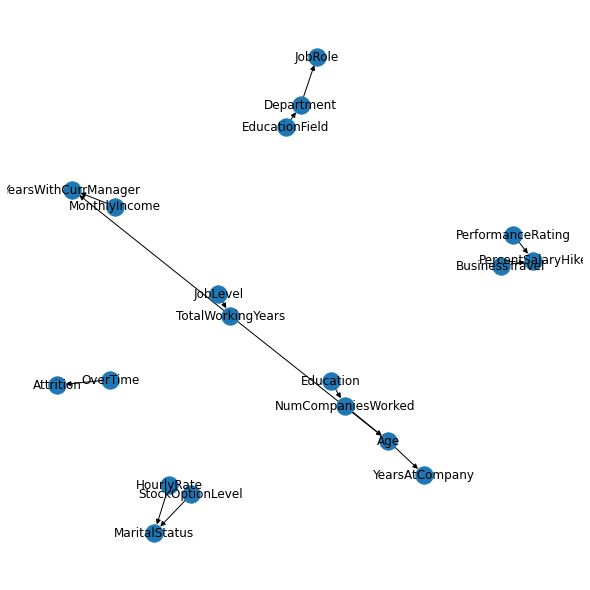

In [21]:
import networkx as nx
import matplotlib.pyplot as plt 

G = nx.MultiDiGraph()

G.add_edges_from(
    estimated_model.edges
)

plt.figure(figsize=(8,8))
nx.draw(G, with_labels = True)#connectionstyle='arc3, rad = 0.1',)

In [ ]:
from pgmpy.estimators import K2Score
scoring_method = K2Score(data=data)
est = HillClimbSearch(data=data)
estimated_model = est.estimate(scoring_method=scoring_method, max_indegree=4, max_iter=int(1e4))
#get_f1_score(estimated_model, model)


  0%|          | 8/10000 [00:11<1:48:35,  1.53it/s] 

### structure learning is extremely "computationally expensive"
we can migitate this problem a little bit asking, which variabels we can discard. E.g. we can't do much about age, gender or marital_status
we also can 

In [ ]:
variables_to_ignore = [
    'Age',
     'Gender',
     'MaritalStatus',
     'RelationshipSatisfaction',
     'Over18',
     'MonthlyIncome',
     'NumCompaniesWorked',
     'Education',
     'EducationField',
     'Department',
     'YearsAtCompany',
     'TotalWorkingYears',
]

# Let's do a quick correlation check here (continuous only)

In [37]:
correlation = data.corr()
#correlation['OverTime'].sort_values()
correlation

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Age,1.000000,0.010661,-0.001686,0.208034,-0.010145,0.010146,0.024287,0.029820,0.509604,-0.004892,...,0.001904,0.053535,0.037510,0.680381,-0.019621,-0.021490,0.311309,0.212901,0.216513,0.202089
DailyRate,0.010661,1.000000,-0.004985,-0.016806,-0.050990,0.018355,0.023381,0.046135,0.002966,0.030571,...,0.000473,0.007846,0.042143,0.014515,0.002453,-0.037848,-0.034055,0.009932,-0.033229,-0.026363
DistanceFromHome,-0.001686,-0.004985,1.000000,0.021042,0.032916,-0.016075,0.031131,0.008783,0.005303,-0.003669,...,0.027110,0.006557,0.044872,0.004628,-0.036942,-0.026556,0.009508,0.018845,0.010029,0.014406
Education,0.208034,-0.016806,0.021042,1.000000,0.042070,-0.027128,0.016775,0.042438,0.101589,-0.011296,...,-0.024539,-0.009118,0.018422,0.148280,-0.025100,0.009819,0.069114,0.060236,0.054254,0.069065
EmployeeNumber,-0.010145,-0.050990,0.032916,0.042070,1.000000,0.017621,0.035179,-0.006888,-0.018519,-0.046247,...,-0.020359,-0.069861,0.062227,-0.014365,0.023603,0.010309,-0.011240,-0.008416,-0.009019,-0.009197
EnvironmentSatisfaction,0.010146,0.018355,-0.016075,-0.027128,0.017621,1.000000,-0.049857,-0.008278,0.001212,-0.006784,...,-0.029548,0.007665,0.003432,-0.002693,-0.019359,0.027627,0.001458,0.018007,0.016194,-0.004999
HourlyRate,0.024287,0.023381,0.031131,0.016775,0.035179,-0.049857,1.000000,0.042861,-0.027853,-0.071335,...,-0.002172,0.001330,0.050263,-0.002334,-0.008548,-0.004607,-0.019582,-0.024106,-0.026716,-0.020123
JobInvolvement,0.029820,0.046135,0.008783,0.042438,-0.006888,-0.008278,0.042861,1.000000,-0.012630,-0.021476,...,-0.029071,0.034297,0.021523,-0.005533,-0.015338,-0.014617,-0.021355,0.008717,-0.024184,0.025976
JobLevel,0.509604,0.002966,0.005303,0.101589,-0.018519,0.001212,-0.027853,-0.012630,1.000000,-0.001944,...,-0.021222,0.021642,0.013984,0.782208,-0.018191,0.037818,0.534739,0.389447,0.353885,0.375281
JobSatisfaction,-0.004892,0.030571,-0.003669,-0.011296,-0.046247,-0.006784,-0.071335,-0.021476,-0.001944,1.000000,...,0.002297,-0.012454,0.010690,-0.020185,-0.005779,-0.019459,-0.003803,-0.002305,-0.018214,-0.027656


In [29]:
data.StandardHours.unique()

array([80])